# DATA 620 Final Project – Recipe Analysis

For their 2011 paper “The flavor web and food pairing principles,” four scientists analyzed 56,498 recipes downloaded 
from three websites—allrecipes.com, epicurious.com, and menupan.com. 
To support their findings, the authors published two datasets. One names the cuisine and ingredients for each recipe. 
The other dataset counts how often any two ingredients appear in the same recipe.

The original research article, Flavor network and the principles of food pairing, can be found 
here: https://www.nature.com/articles/srep00196

Data downloads consist of the following two files:
    
srep00196-s2.csv:
Counts how many times any two ingredients appear together in any recipe.

srep00196-s3.csv:
One record per recipe with the ingredients listed in columns.

# Loading Libraries

In [37]:
import pandas as pd
import numpy as np
from IPython.display import Markdown

import nltk
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.tokenize import word_tokenize

import networkx as nx
from networkx.algorithms import bipartite as bi

from scipy import stats
import math
import random
random.seed(250)

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (15,12)

# Loading Data

In [95]:
file_name ='srep00196-s2.csv'

In [96]:
file_name ='srep00196-s3.csv'

columns = ['Cuisine', 'ingred1','ingred2','ingred3','ingred4','ingred5','ingred6','ingred7','ingred8','ingred9',
           'ingred10','ingred11','ingred12','ingred13','ingred14','ingred15','ingred16','ingred17','ingred18',
           'ingred19','ingred20','ingred21','ingred22','ingred23','ingred24','ingred25','ingred26','ingred27',
           'ingred28','ingred29','ingred30','ingred31','ingred32']

recipes = pd.read_csv(file_name, header=None, skiprows=4, names=columns, encoding = 'utf-8',)

recipes.head()
print("There are "+str(recipes.shape[0])+ " recipes with a maximum of "+str(recipes.shape[1]-1)+" ingredients each.")

/Users/hazalgunduz/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Cuisine        ingred1   ingred2    ingred3   ingred4   ingred5   ingred6  \
0  African        chicken  cinnamon  soy_sauce     onion    ginger       NaN   
1  African  cane_molasses    ginger      cumin    garlic  tamarind     bread   
2  African         butter    pepper      onion  cardamom   cayenne    ginger   
3  African      olive_oil    pepper      wheat      beef     onion  cardamom   
4  African          honey     wheat      yeast       NaN       NaN       NaN   

          ingred7  ingred8   ingred9 ingred10 ingred11 ingred12     ingred13  \
0             NaN      NaN       NaN      NaN      NaN      NaN          NaN   
1       coriander  vinegar     onion     beef  cayenne  parsley  wheat_bread   
2  cottage_cheese   garlic  brassica      NaN      NaN      NaN          NaN   
3           cumin   garlic      rice     leek      NaN      NaN          NaN   
4             NaN      NaN       NaN      NaN      NaN      NaN          NaN   

  ingred14       ingred15 ingred16 ingred17 ingred18 ingred19 ingred20  \
0      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
1   yogurt  vegetable_oil      egg      NaN      NaN      NaN      NaN   
2      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN            NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN            NaN      NaN      NaN      NaN      NaN      NaN   

  ingred21 ingred22 ingred23 ingred24 ingred25 ingred26 ingred27 ingred28  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  ingred29 ingred30 ingred31 ingred32  
0      NaN      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN

There are 56498 recipes with a maximum of 32 ingredients each.


Creating a Corpus from Data

First, we write how to get all the materials into a string that can be written to a file to 
create every text in our collection. We took the code below to do what we need.

In [39]:
for index, r in recipes.head().iterrows():
    string = ""
    for col in r[1:32]:
        if type(col) == str:
            string = string+str(col)+" "
    print(string)

chicken cinnamon soy_sauce onion ginger 
cane_molasses ginger cumin garlic tamarind bread coriander vinegar onion beef cayenne parsley wheat_bread yogurt vegetable_oil egg 
butter pepper onion cardamom cayenne ginger cottage_cheese garlic brassica 
olive_oil pepper wheat beef onion cardamom cumin garlic rice leek 
honey wheat yeast 


# Data Analysis

## Distribution of Recipes

In [40]:
recipes['Cuisine'].value_counts()

NorthAmerican       41524
SouthernEuropean     4180
LatinAmerican        2917
WesternEuropean      2659
EastAsian            2512
MiddleEastern         645
SouthAsian            621
SoutheastAsian        457
EasternEuropean       381
African               352
NorthernEuropean      250
Name: Cuisine, dtype: int64

North American recipes represent a disproportionate number of recipes in the dataset, 
with 41,524 out of a total of 56,498 recipes and 6 out of 11 cuisines, each containing only 
250 to 645 recipes. Therefore, the following analysis of ingredients in the recipe dataset in 
general will tend towards North American Cuisine. Future analyzes with randomly selected and 
equally sized subsets of each cuisine can provide more insight into the overall picture. 
Even selecting subsets of a size possibly proportional to populations can give us important 
information about the relative global importance of recipe ingredients.

## Distribution of Number of Ingredients

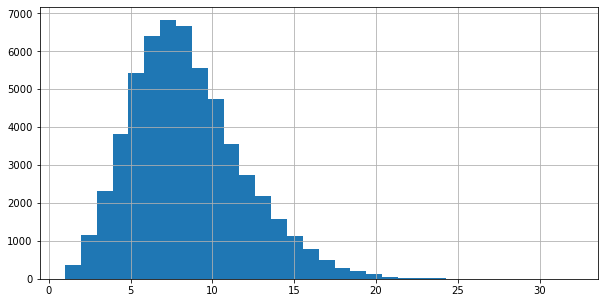

In [81]:
recipes['#of_ingred'] = 32-recipes.isnull().sum(axis=1)

recipes['#of_ingred'].hist(bins=32, figsize=(10,5));

In [9]:
round(recipes['#of_ingred'].mean(), 2)

8.22

Each of the recipes has an ingredient range from 1 to 32. 
The distribution of ingredients in all recipes slopes slightly to the right. 
In general, most recipes have between 2 and 15 ingredients, with an overall average of 8.22 
ingredients per recipe.

## Average Number of Ingredients by Cuisine

In [10]:
num_ing = recipes.groupby('Cuisine').mean().sort_values(by=['#of_ingred'], ascending=False).reset_index().iloc[:,[0,1]]
num_ing

Cuisine  #of_ingred
0     SoutheastAsian   11.317287
1            African   10.451705
2         SouthAsian   10.286634
3      LatinAmerican    9.379499
4          EastAsian    8.956210
5   SouthernEuropean    8.860766
6      MiddleEastern    8.389147
7    EasternEuropean    8.388451
8    WesternEuropean    8.025950
9      NorthAmerican    7.962094
10  NorthernEuropean    6.824000

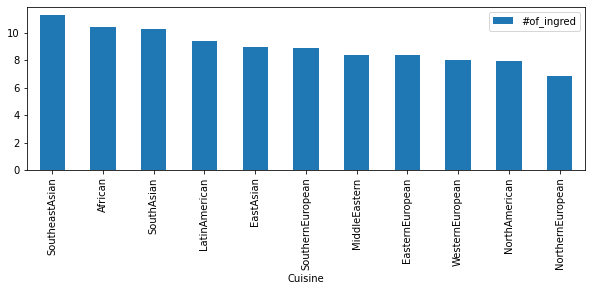

In [11]:
num_ing.plot.bar(x='Cuisine', figsize=(10,3));

Southeast Asian recipes have the most ingredients per recipe, with an average of 11.32 
ingredients. African and South Asian recipes also have an average of more than 10 ingredients. 
Northern European recipes have the lowest average ingredient count at 6.82, slightly more than
half the average for Southeast Asian recipes, and North American recipes have the second least
number of ingredients, with 7.96 on average.

## Distribution of the Number of Ingredients by Cuisine

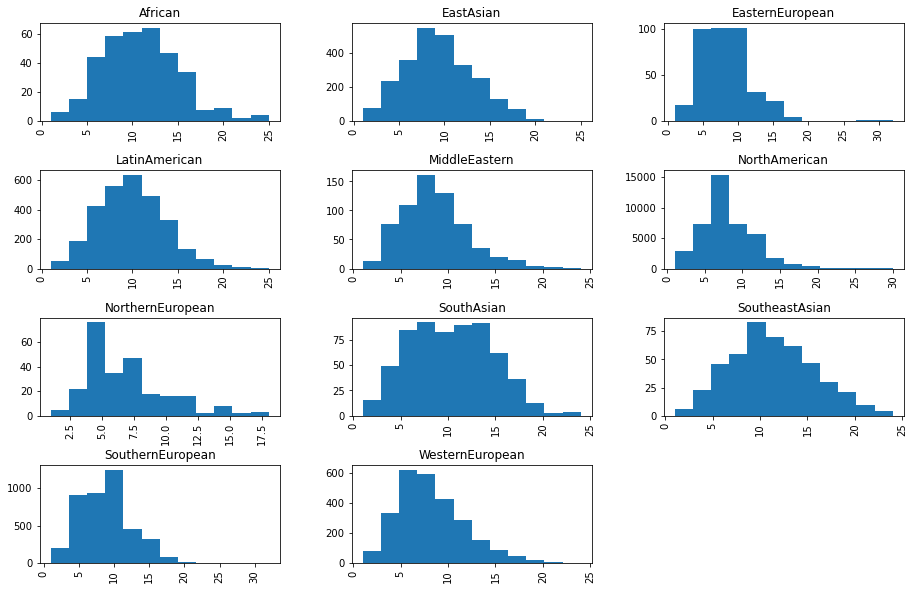

In [12]:
recipes['#of_ingred'].hist(by=recipes['Cuisine'], bins=12, figsize=(15,10));

While the distribution peak of all European cuisines as well as North American cuisine falls 
below 10 ingredients, the peak of Southeast Asian, African, South Asian and Latin American 
cuisines falls to about 10 ingredients. While we can see variations of Eastern European, 
Southern European and Northern European cuisines, the rest range from 25 or less to 30.

## Most Common Ingredients Overall

In [13]:
recipes['recipe#'] = recipes.index+1

In [14]:
ingredient_list = pd.melt(recipes, id_vars=['Cuisine','recipe#'], value_vars=columns[1:]).dropna()
ingredient_list.rename(columns={"variable":"ingred#", "value":"ingredient"}, inplace=True)
#ingredient_list.head()
#ingredient_list.tail()
len(ingredient_list)

464407

In [15]:
ingredient_counts = pd.DataFrame(ingredient_list.ingredient.value_counts())
ingredient_counts.shape
ingredient_counts.head(10)

(381, 1)

ingredient
egg                 20951
wheat               20782
butter              20744
onion               18031
garlic              16893
milk                12895
vegetable_oil       10759
cream               10152
tomato               9909
olive_oil            9844

There are 464,407 total ingredients and 381 unique ingredients across all 56,498 recipes. 
Egg is the most popular ingredient, followed by wheat, butter, onion and garlic.

In [83]:
ingredient_counts.tail(17)

ingredient
strawberry_juice           2
jasmine_tea                1
strawberry_jam             1
emmental_cheese            1
jamaican_rum               1
sturgeon_caviar            1
roasted_nut                1
roasted_pecan              1
muscat_grape               1
angelica                   1
roasted_hazelnut           1
pelargonium                1
lilac_flower_oil           1
mate                       1
beech                      1
durian                     1
geranium                   1

## Most Common Ingredients by Cuisine

In [47]:
cuisine_counts = pd.DataFrame(ingredient_list.groupby('Cuisine').ingredient.value_counts())
cuisine_counts.columns = ["count"]

In [48]:
cuisine_counts.groupby('Cuisine').head(1)

count
Cuisine          ingredient       
African          olive_oil     196
EastAsian        soy_sauce    1358
EasternEuropean  butter        201
LatinAmerican    cayenne      1946
MiddleEastern    wheat         272
NorthAmerican    butter      17088
NorthernEuropean butter        160
SouthAsian       cumin         375
SoutheastAsian   garlic        284
SouthernEuropean olive_oil    2612
WesternEuropean  butter       1395

The best ingredient varies by cuisine, but the best ingredient overall, eggs, doesn't rank 
high for any particular cuisine. This may indicate that eggs as a component are 
cross-culturally related, while other common components may be more culturally specific. 
The third most popular ingredient overall, butter tops the list for 4 cuisines on our list: 
Eastern European, North American, Northern European, and Western European.

## Top 5 Most Common Ingredients by Cuisine

In [49]:
cuisine_counts.groupby('Cuisine').head(5)

count
Cuisine          ingredient          
African          olive_oil        196
                 onion            189
                 cumin            166
                 garlic           160
                 cayenne          116
EastAsian        soy_sauce       1358
                 garlic          1302
                 scallion        1188
                 cayenne         1008
                 sesame_oil       937
EasternEuropean  butter           201
                 egg              197
                 wheat            197
                 onion            162
                 cream            111
LatinAmerican    cayenne         1946
                 onion           1906
                 garlic          1752
                 tomato          1579
                 corn             868
MiddleEastern    wheat            272
                 olive_oil        262
                 egg              239
                 onion            221
                 garlic           212
NorthAmerican    butter         17088
                 egg            16738
                 wheat          16532
                 onion          12311
                 milk           10996
NorthernEuropean butter           160
                 wheat            145
                 egg              132
                 cream             72
                 milk              56
SouthAsian       cumin            375
                 turmeric         319
                 onion            316
                 cayenne          300
                 garlic           295
SoutheastAsian   garlic           284
                 fish             226
                 cayenne          191
                 vegetable_oil    180
                 cilantro         163
SouthernEuropean olive_oil       2612
                 garlic          2181
                 tomato          1593
                 onion           1451
                 egg             1097
WesternEuropean  butter          1395
                 egg             1303
                 wheat           1278
                 onion            720
                 milk             693

The same 4 Eastern European, North American, Northern European, and Western European cuisines 
all share the same top 5 ingredients: butter, eggs, wheat, milk/cream, and onions. 
Onion, garlic, and olive oil regularly make it to the top 5 lists of other cuisines, and 
it's no surprise that they're often featured in slots 4, 5, and 10, respectively. 
Not surprisingly, eggs show up in 6 out of 11 cuisines.

## Top ingredients as percent of the total number of recipes by cuisine

In [50]:
cuisine_props = pd.DataFrame(ingredient_list.groupby('Cuisine').ingredient.value_counts(normalize=True)*100)
cuisine_props.columns = ["percent"]

In [51]:
cuisine_props.reset_index().groupby('Cuisine').head(1).sort_values(by=['percent'], ascending=False)

Cuisine ingredient   percent
1478  NorthernEuropean     butter  9.378664
637      LatinAmerican    cayenne  7.112573
2042  SouthernEuropean  olive_oil  7.052217
2332   WesternEuropean     butter  6.536713
439    EasternEuropean     butter  6.289111
197          EastAsian  soy_sauce  6.036092
1653        SouthAsian      cumin  5.870382
1858    SoutheastAsian     garlic  5.491106
0              African  olive_oil  5.327535
1124     NorthAmerican     butter  5.168503
897      MiddleEastern      wheat  5.026797

The best ingredients in each cuisine range from just over 5% to 7% of all recipes for each 
cuisine, with the exception of Northern European cuisine, where over 9% of the recipes have 
butter as the top ingredient!

In [52]:
cuisine_props.sort_values(by=['percent'], ascending=False).head(20)

percent
Cuisine          ingredient          
NorthernEuropean butter      9.378664
                 wheat       8.499414
                 egg         7.737397
LatinAmerican    cayenne     7.112573
SouthernEuropean olive_oil   7.052217
LatinAmerican    onion       6.966374
WesternEuropean  butter      6.536713
LatinAmerican    garlic      6.403509
EasternEuropean  butter      6.289111
                 wheat       6.163955
                 egg         6.163955
WesternEuropean  egg         6.105618
EastAsian        soy_sauce   6.036092
WesternEuropean  wheat       5.988473
SouthernEuropean garlic      5.888547
SouthAsian       cumin       5.870382
EastAsian        garlic      5.787181
LatinAmerican    tomato      5.771199
SoutheastAsian   garlic      5.491106
African          olive_oil   5.327535

When looking at the top 20 ingredients as percentages of their respective cuisines, a slightly 
different picture emerges. No North American ingredients appear on the list because even the 
most common ingredient, some ingredients don't appear as often in North American cuisines as 
they do in other cuisines, suggesting that there may be more variety of ingredients between 
recipes in North American cooking. At the other end of the spectrum, Northern, Western, and 
Eastern European cuisines all have the top three ingredients, and Latin America has the top 4 
on the list, suggesting that there may be more in common or less variety of ingredients among 
the recipes in their cuisine.

## Ingredient Pairings

To see which ingredients come together most commonly for each cuisine, and to see the 
similarities and differences between common pairings by cuisine, we first need to reshape our 
data into a dataframe that includes all pairings from all recipes.

In [55]:
pairs = pd.DataFrame({'Cuisine':[], 'ingred1':[], 'ingred2':[]})
for i in range(1,32):
    for j in range((i+1),33):
        temp=recipes.iloc[:,[0,i,j]]
        temp.columns=['Cuisine','ingred1','ingred2']
        temp=temp.dropna()
        pairs=pairs.append(temp,ignore_index=True)

In [56]:
pairs.head()
pairs.shape

Cuisine        ingred1   ingred2
0  African        chicken  cinnamon
1  African  cane_molasses    ginger
2  African         butter    pepper
3  African      olive_oil    pepper
4  African          honey     wheat

(2036125, 3)

In [57]:
pairs = pairs.dropna()
pairs.shape

(2036125, 3)

There are 2,036,125 records, but we reduced that number by summing all duplicate entries into 
one row and adding a column for counts. Because we know some cuisines are more or less 
represented, we've also included a column for the percentage of total recipes for each 
cuisine that includes this pairing. The resulting data frame is below.

In [58]:
pair_counts = pairs.reset_index().groupby(['Cuisine','ingred1','ingred2'], as_index=False).count()
pair_counts.rename(columns={"index":"counts"}, inplace=True)
pair_counts['total'] = pair_counts.groupby('Cuisine').counts.transform('sum')
pair_counts['percent'] = pair_counts['counts']/pair_counts['total']*100
pair_counts.head()
pair_counts.shape

Cuisine ingred1     ingred2  counts  total   percent
0  African  almond  anise_seed       1  20524  0.004872
1  African  almond     apricot       2  20524  0.009745
2  African  almond      barley       2  20524  0.009745
3  African  almond         bay       2  20524  0.009745
4  African  almond        bean       1  20524  0.004872

(123181, 6)

## Top Ingredient Pairings

In [59]:
pair_counts.sort_values(by='counts', ascending=False, inplace=True)
pair_counts.head(10)

Cuisine        ingred1  ingred2  counts    total   percent
74966  NorthAmerican          wheat      egg   10931  1395965  0.783043
43137  NorthAmerican         butter    wheat   10562  1395965  0.756609
42925  NorthAmerican         butter      egg    9294  1395965  0.665776
75032  NorthAmerican          wheat     milk    7315  1395965  0.524010
42995  NorthAmerican         butter     milk    6445  1395965  0.461688
51239  NorthAmerican            egg     milk    6405  1395965  0.458822
73538  NorthAmerican        vanilla      egg    5677  1395965  0.406672
75160  NorthAmerican          wheat  vanilla    5645  1395965  0.404380
43127  NorthAmerican         butter  vanilla    5528  1395965  0.395998
73987  NorthAmerican  vegetable_oil      egg    4839  1395965  0.346642

In [60]:
pair_counts.sort_values(by='percent', ascending=False, inplace=True)
pair_counts.head(10)

Cuisine    ingred1  ingred2  counts   total   percent
76798   NorthernEuropean     butter    wheat     116    6249  1.856297
76722   NorthernEuropean     butter      egg      96    6249  1.536246
79059   NorthernEuropean      wheat      egg      85    6249  1.360218
26676      LatinAmerican      onion  cayenne    1389  134200  1.035022
18862    EasternEuropean      wheat      egg     146   14224  1.026434
101651  SouthernEuropean  olive_oil   garlic    1730  172245  1.004383
30036      LatinAmerican     tomato    onion    1312  134200  0.977645
110061   WesternEuropean     butter    wheat     902   93223  0.967572
14918    EasternEuropean     butter    wheat     136   14224  0.956130
14817    EasternEuropean     butter      egg     131   14224  0.920979

## Top 3 Pairings by Cuisine

In [61]:
pair_counts.sort_values(by=['Cuisine','percent'], ascending=[True, False]).groupby('Cuisine').head(3)

Cuisine     ingred1        ingred2  counts    total   percent
3296             African   olive_oil          cumin     120    20524  0.584681
3308             African   olive_oil         garlic     106    20524  0.516469
3344             African   olive_oil          onion      98    20524  0.477490
6851           EastAsian     cayenne       scallion     630   107684  0.585045
11868          EastAsian    scallion         garlic     620   107684  0.575759
12209          EastAsian  sesame_oil      soy_sauce     585   107684  0.543256
18862    EasternEuropean       wheat            egg     146    14224  1.026434
14918    EasternEuropean      butter          wheat     136    14224  0.956130
14817    EasternEuropean      butter            egg     131    14224  0.920979
26676      LatinAmerican       onion        cayenne    1389   134200  1.035022
30036      LatinAmerican      tomato          onion    1312   134200  0.977645
29944      LatinAmerican      tomato        cayenne    1218   134200  0.907601
37794      MiddleEastern       wheat            egg     159    24238  0.655995
35340      MiddleEastern   olive_oil         garlic     145    24238  0.598234
35375      MiddleEastern   olive_oil          onion     121    24238  0.499216
74966      NorthAmerican       wheat            egg   10931  1395965  0.783043
43137      NorthAmerican      butter          wheat   10562  1395965  0.756609
42925      NorthAmerican      butter            egg    9294  1395965  0.665776
76798   NorthernEuropean      butter          wheat     116     6249  1.856297
76722   NorthernEuropean      butter            egg      96     6249  1.536246
79059   NorthernEuropean       wheat            egg      85     6249  1.360218
81573         SouthAsian       cumin       turmeric     269    36060  0.745979
81290         SouthAsian   coriander       turmeric     246    36060  0.682196
81187         SouthAsian   coriander          cumin     246    36060  0.682196
88086     SoutheastAsian      garlic  vegetable_oil     130    31513  0.412528
87869     SoutheastAsian        fish         garlic     116    31513  0.368102
88132     SoutheastAsian      ginger         garlic     108    31513  0.342716
101651  SouthernEuropean   olive_oil         garlic    1730   172245  1.004383
106338  SouthernEuropean      tomato      olive_oil    1069   172245  0.620628
106292  SouthernEuropean      tomato         garlic    1044   172245  0.606113
110061   WesternEuropean      butter          wheat     902    93223  0.967572
122653   WesternEuropean       wheat            egg     843    93223  0.904283
109895   WesternEuropean      butter            egg     813    93223  0.872102

## Network and Text Analysis of Individual Cuisines

In the next sections, we analyzed the best ingredient pairs for each kitchen through network charts and the ingredients that make up half of each kitchen's total ingredients, as well as the top 50 ingredients in each kitchen through text analysis.
To make visualizations easier to understand, ingredient pairs have been filtered by number of occurrences to include approximately 80-90 of the best pairs for each cuisine.

## Create Functions for Text Analysis

In [62]:
def setup(category):
    fdist = nltk.FreqDist(corpus.words(categories = category))
    ingredients_sorted = sorted(list(corpus.words(categories = category)))
    return(fdist, ingredients_sorted)

In [64]:
def cuisine(category, ingredients_sorted):
    ing = len(corpus.words(categories = category))
    rec = len(corpus.sents(categories = category))
    uni_ing = len(set(ingredients_sorted))
    mkdwn = Markdown("""The **{category}** recipes in our dataset include **{ing} total ingredients** listed in 
    **{rec} recipes** with **{uni_ing} unique ingredients**.""".format(category=category, ing=ing, 
                                                                       rec=rec, uni_ing=uni_ing))
    return(mkdwn)

In [65]:
def half(category, ingredients_sorted, fdist):
    top = top_half(ingredients_sorted, fdist)
    mkdwn = Markdown("""The following **{top} ingredients represent half of the total ingredients** 
    in the **{category}** recipes.""".format(top=top, category=category))
    return(mkdwn)

## African Cuisine

In [66]:
pair_countsA=pair_counts[(pair_counts['counts']>30) & (pair_counts['Cuisine']=='African')]
pair_countsA.shape

(81, 6)

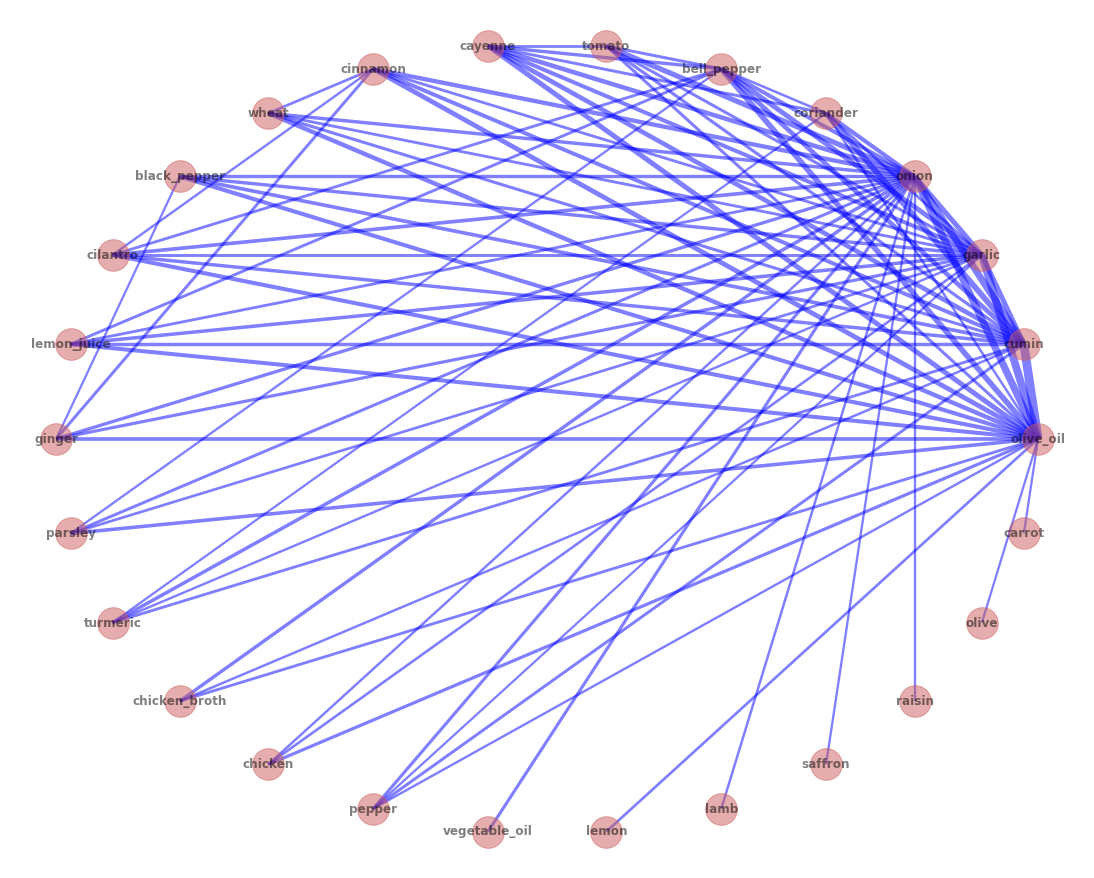

In [73]:
A=nx.from_pandas_edgelist(pair_countsA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in A.edges(data=True)]
nx.draw_circular(A, with_labels=True, node_color="indianred", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="blue", alpha=0.5)

The importance of spices in African cuisine really stands out in the chart above, which 
includes onions, garlic, cumin, turmeric, coriander, paprika, ginger, parsley, cinnamon, and 
saffron.

The African recipes in our dataset include 3679 total ingredients listed in 352 recipes with 197 unique ingredients.

## East Asian Cuisine

In [69]:
pair_countsEA=pair_counts[(pair_counts['counts']>200) & (pair_counts['Cuisine']=='EastAsian')]
pair_countsEA.shape

(81, 6)

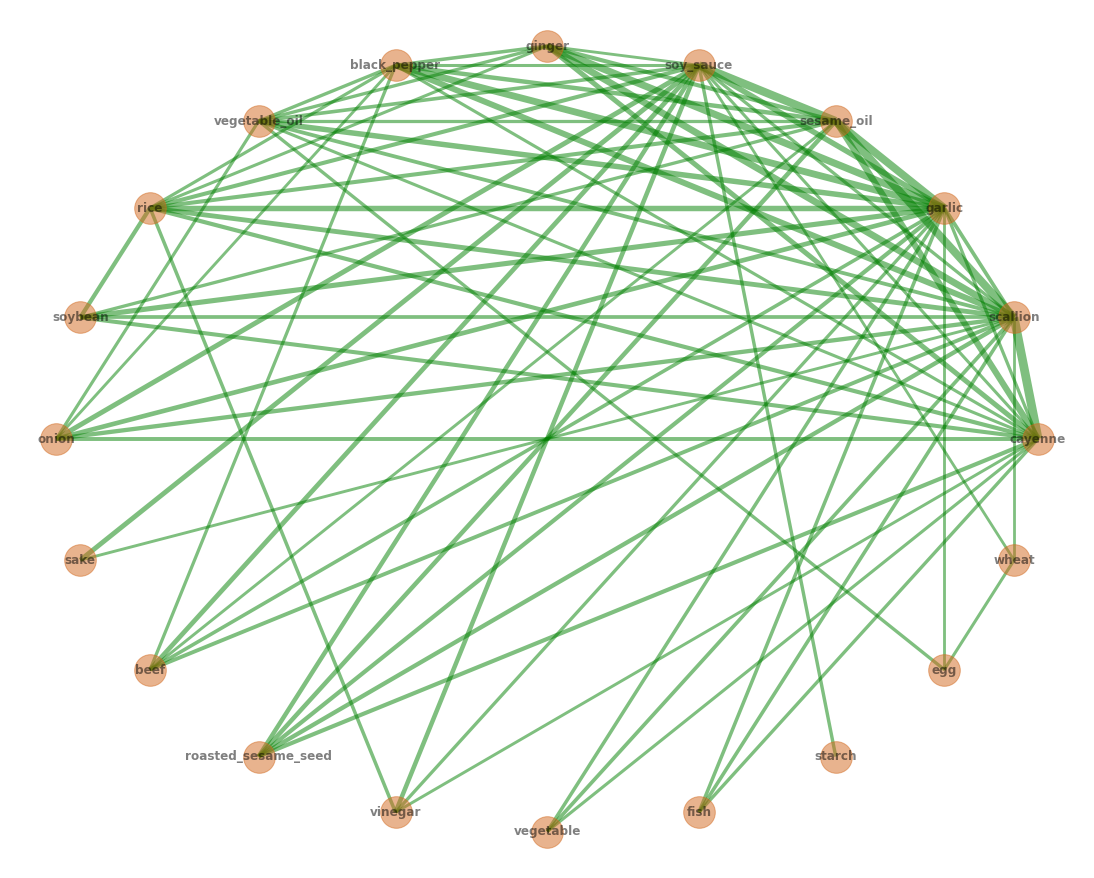

In [72]:
EA=nx.from_pandas_edgelist(pair_countsEA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in EA.edges(data=True)]
nx.draw_circular(EA, with_labels=True, node_color="chocolate", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="green", alpha=0.5)

East Asian cooking is clearly heavily influenced by rice, cayenne, ginger, soy sauce, scallions, garlic, and sesame oil.

The East Asian recipes in our dataset include 22498 total ingredients listed in 2512 recipes with 242 unique ingredients.

## Eastern European Cuisine

In [71]:
pair_countsEE=pair_counts[(pair_counts['counts']>18) & (pair_counts['Cuisine']=='EasternEuropean')]
pair_countsEE.shape

(85, 6)

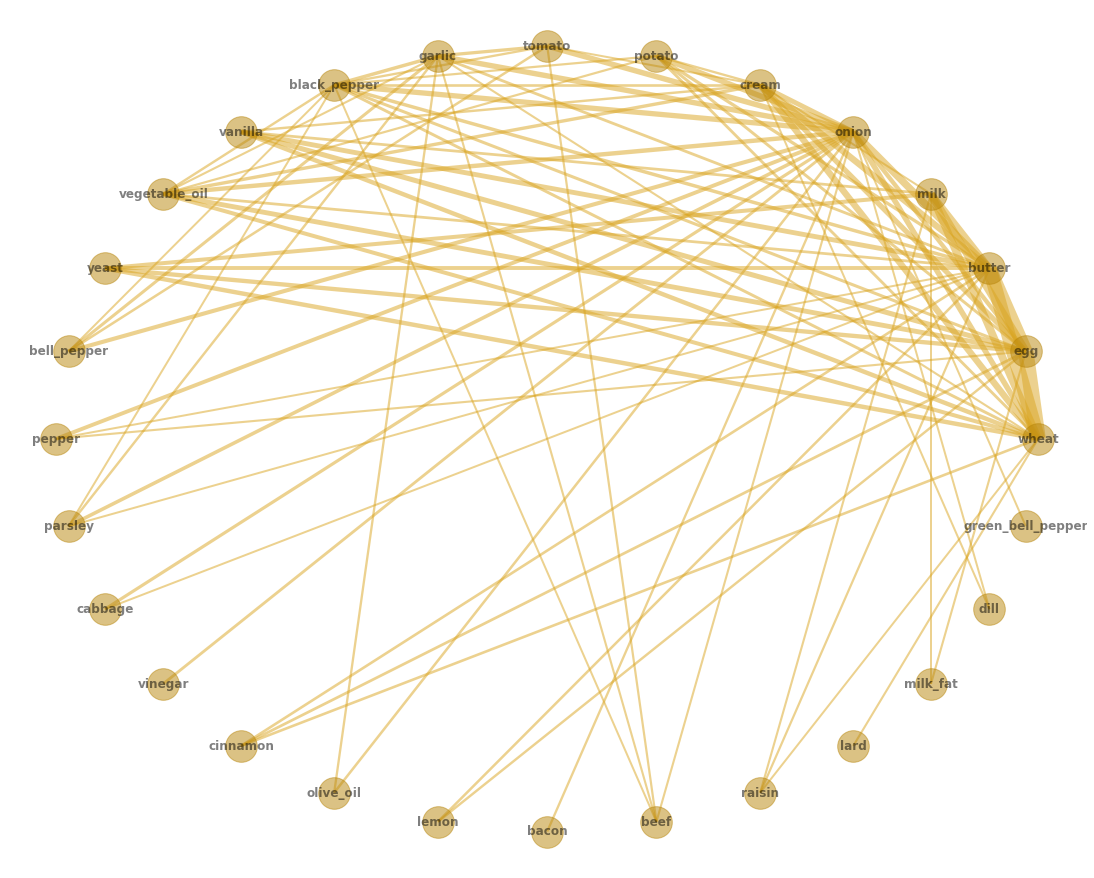

In [75]:
EE=nx.from_pandas_edgelist(pair_countsEE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in EE.edges(data=True)]
nx.draw_circular(EE, with_labels=True, node_color="darkgoldenrod", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="goldenrod", alpha=0.5)

The centrality of wheat, butter and egg in Eastern European cuisine is very evident in the 
thick triangle formed by the edges between them in the graphic above. 
The inclusion of yeast in the chart with its edges connecting it to the same three ingredients
and milk likely indicates breads.

The EasternEuropean recipes in our dataset include 3195 total ingredients listed in 381 recipes
with 198 unique ingredients.

## Latin American Cuisine

In [76]:
pair_countsLA=pair_counts[(pair_counts['counts']>220) & (pair_counts['Cuisine']=='LatinAmerican')]
pair_countsLA.shape

(86, 6)

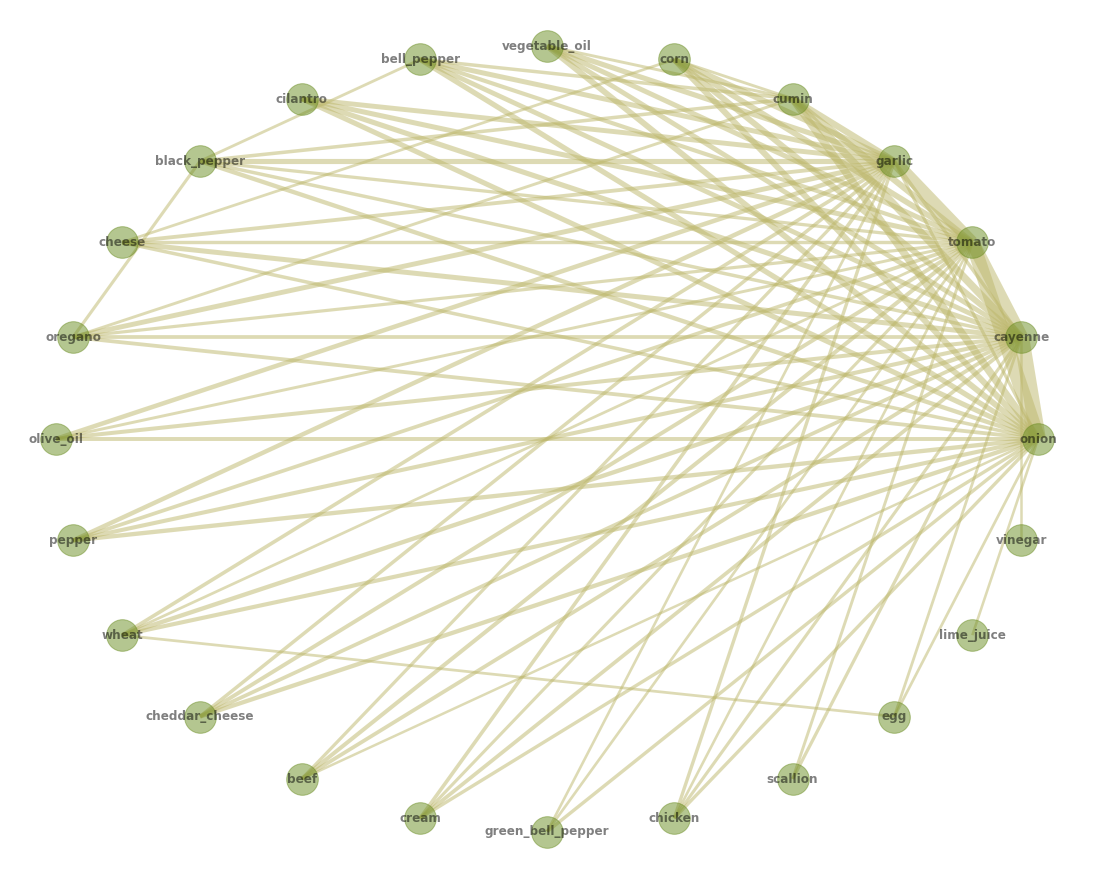

In [77]:
LA=nx.from_pandas_edgelist(pair_countsLA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in LA.edges(data=True)]
nx.draw_circular(LA, with_labels=True, node_color="olivedrab", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="darkkhaki", alpha=0.5)

Onions, garlic, cayenne, and tomatoes are at the center of Latin American dishes and are 
featured in the graphic above with the thick edges that tie them all together.

The Latin American recipes in our dataset include 27360 total ingredients listed in 2917 recipes with 260 unique ingredients.

## Middle Eastern Cuisine

In [78]:
pair_countsME=pair_counts[(pair_counts['counts']>29) & (pair_counts['Cuisine']=='MiddleEastern')]
pair_countsME.shape

(84, 6)

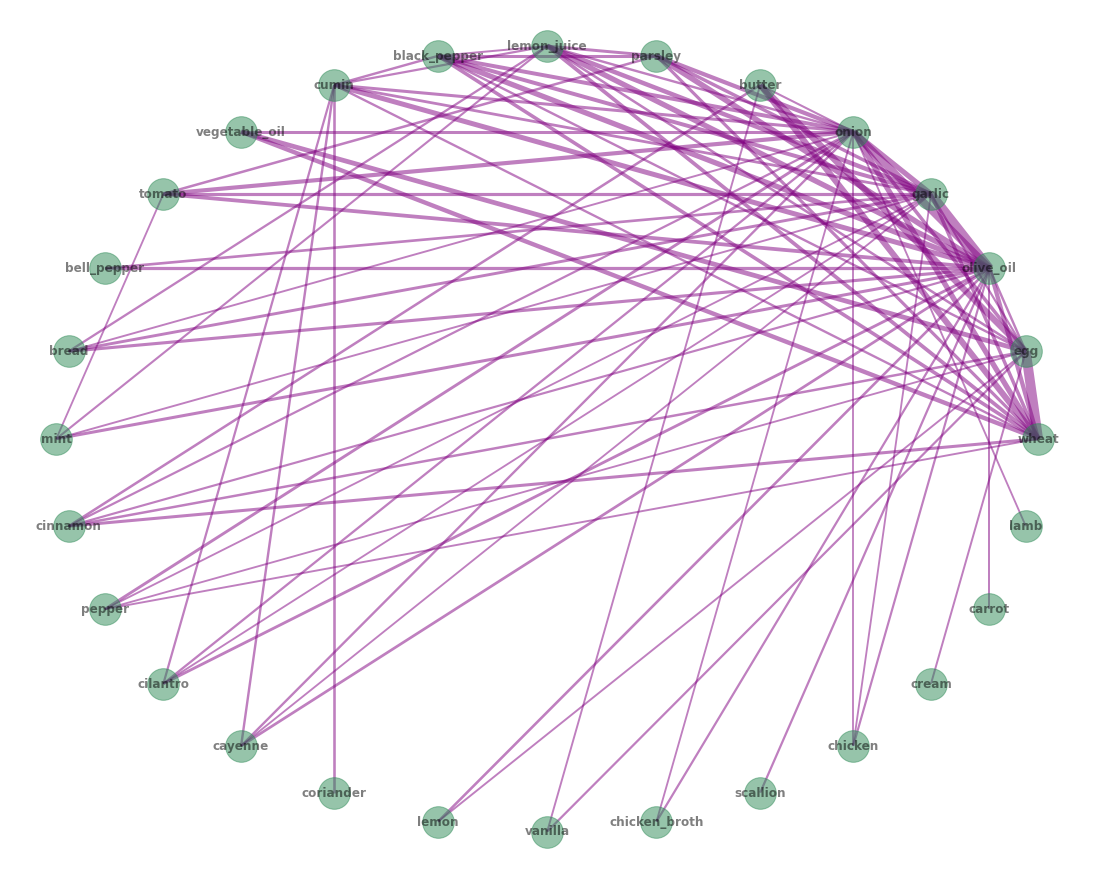

In [79]:
ME=nx.from_pandas_edgelist(pair_countsME, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in ME.edges(data=True)]
nx.draw_circular(ME, with_labels=True, node_color="seagreen", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="purple", alpha=0.5)

Olive oil, lemon juice, wheat, onion, garlic and eggs look like the most heavily connected foods in Mediterranean cuisine.

The MiddleEastern recipes in our dataset include 5411 total ingredients listed in 645 recipes with 227 unique ingredients.


## North American Cuisine

In [108]:
pair_countsNA=pair_counts[(pair_counts['counts']>1500) & (pair_counts['Cuisine']=='NorthAmerican')]
pair_countsNA.shape

(81, 6)

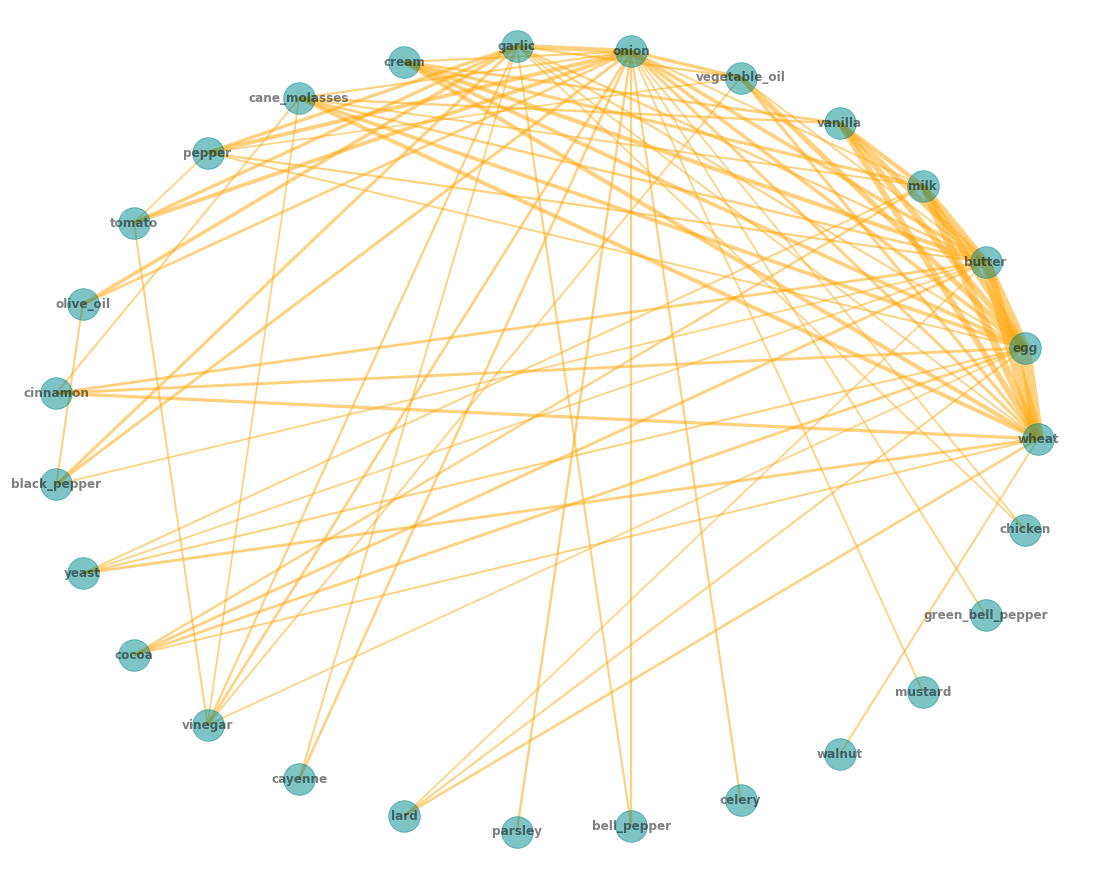

In [110]:
NA=nx.from_pandas_edgelist(pair_countsNA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in NA.edges(data=True)]
nx.draw_circular(NA, with_labels=True, node_color="darkcyan", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="orange", alpha=0.5)

North American cuisine features milk and wheat, butter and eggs front and center. In the graph above, we can see two thick overlapping triangles formed by the sides between them. The inclusion of yeast here also indicates baked goods, possibly breads, but we also see vanilla, cocoa and cane sugar molasses, which can indicate desserts.

The NorthAmerican recipes in our dataset include 330618 total ingredients listed in 41524 recipes with 354 unique ingredients.

## Northern European Cuisine

In [112]:
pair_countsNE=pair_counts[(pair_counts['counts']>8) & (pair_counts['Cuisine']=='NorthernEuropean')]
pair_countsNE.shape

(91, 6)

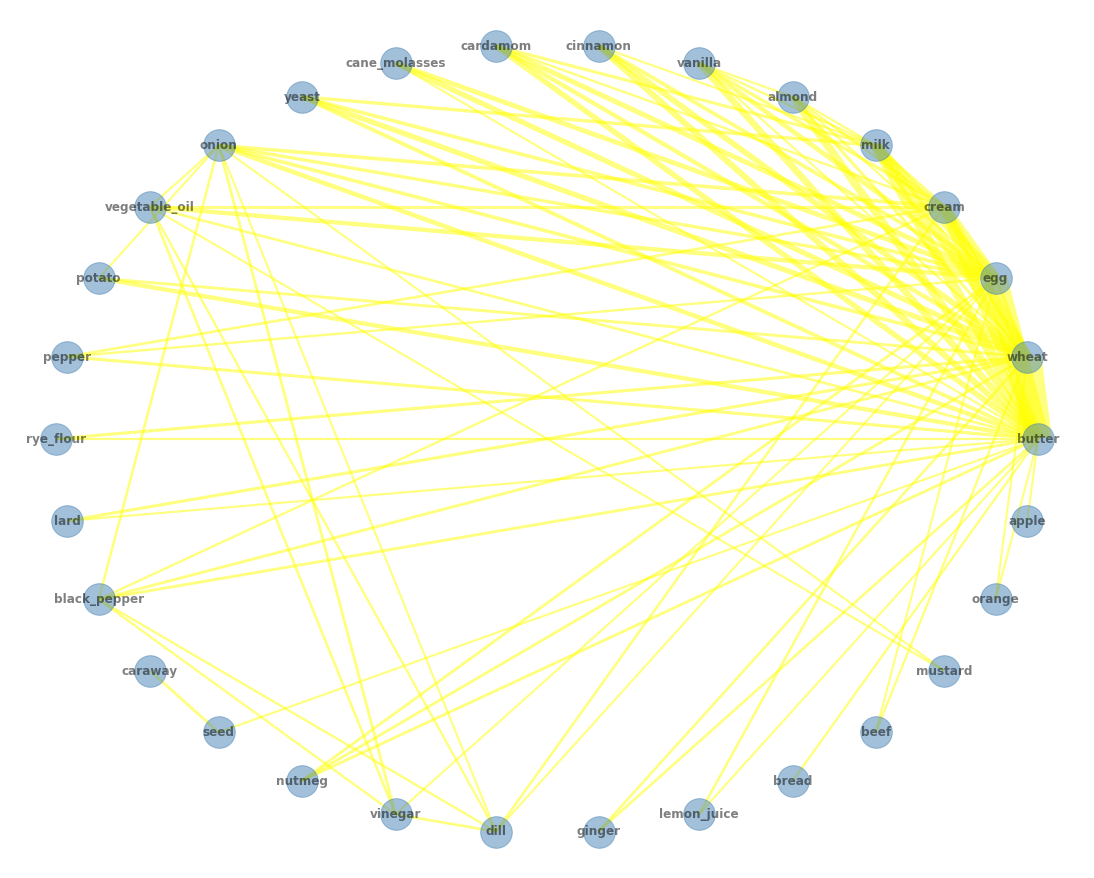

In [114]:
NE=nx.from_pandas_edgelist(pair_countsNE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in NE.edges(data=True)]
nx.draw_circular(NE, with_labels=True, node_color="steelblue", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="yellow", alpha=0.5)

We see heavier links between wheat, butter, and eggs in Northern European cuisine than in Eastern European or North American cuisine. Here we again see yeast denoting bakery products such as bread, but again we see apples and oranges denoting sweets, as well as vanilla and cane molasses.

The Northern European recipes in our dataset include 1706 total ingredients listed in 250 recipes with 175 unique ingredients.


## South Asian Cuisine

In [115]:
pair_countsSA=pair_counts[(pair_counts['counts']>62) & (pair_counts['Cuisine']=='SouthAsian')]
pair_countsSA.shape

(84, 6)

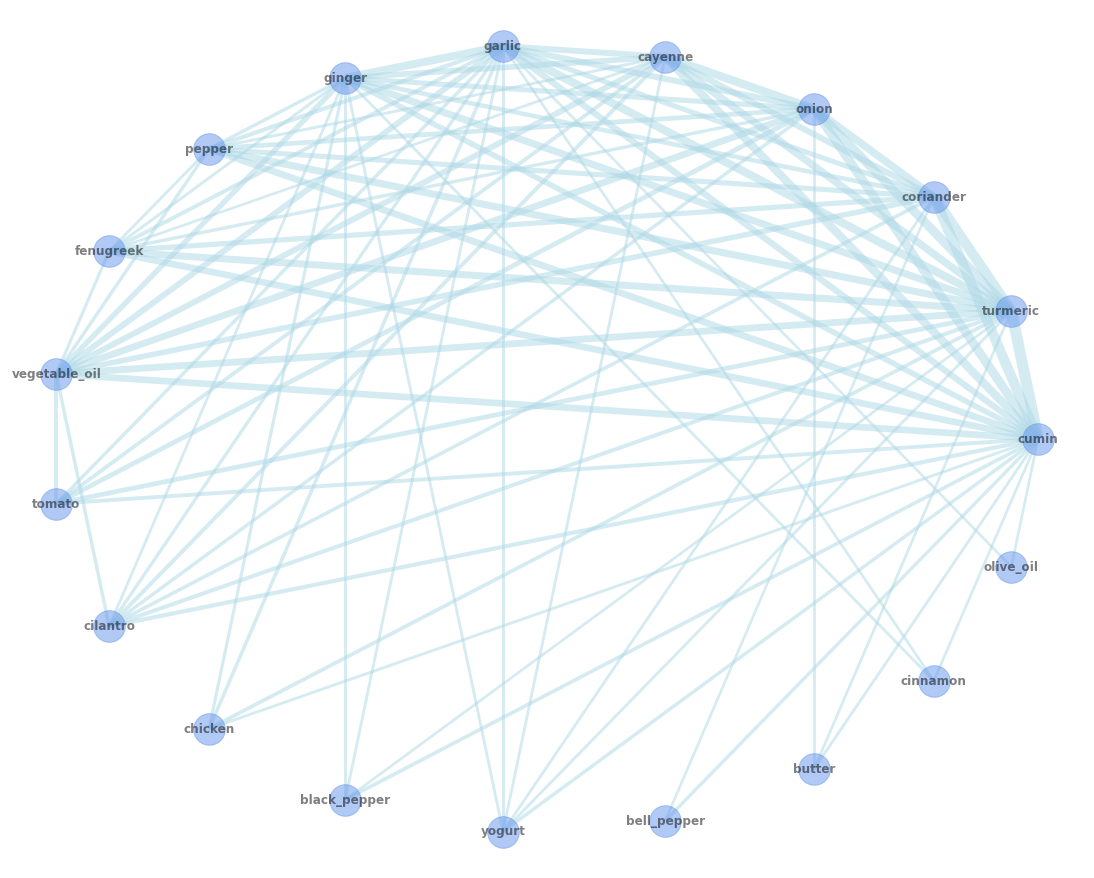

In [117]:
SA=nx.from_pandas_edgelist(pair_countsSA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SA.edges(data=True)]
nx.draw_circular(SA, with_labels=True, node_color="cornflowerblue", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="lightblue", alpha=0.5)

We find that spices are central to South Asian cuisine: onions, garlic, cumin, turmeric, coriander, coriander, paprika, ginger, cinnamon, fenugreek, chili and black pepper.
    
The South Asian recipes in our dataset include 6388 total ingredients listed in 621 recipes with 205 unique ingredients.

## Southeast Asian Cuisine

In [118]:
pair_countsSEA=pair_counts[(pair_counts['counts']>45) & (pair_counts['Cuisine']=='SoutheastAsian')]
pair_countsSEA.shape

(81, 6)

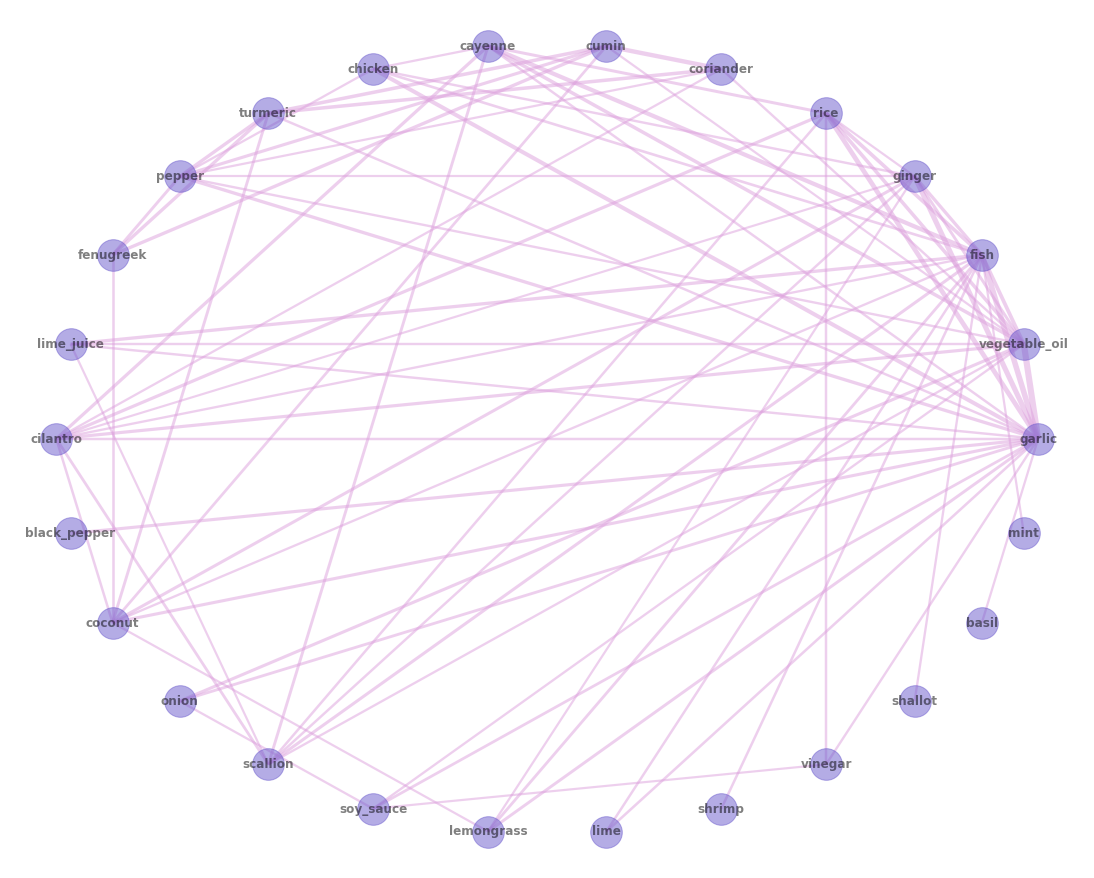

In [119]:
SEA=nx.from_pandas_edgelist(pair_countsSEA, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SEA.edges(data=True)]
nx.draw_circular(SEA, with_labels=True, node_color="slateblue", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="plum", alpha=0.5)

Southeast Asian cuisine is the first cuisine we see in the chart, where meat, especially fish, is used as the most prominent ingredient. Fish depends on most of the other ingredients.

The Southeast Asian recipes in our dataset include 5172 total ingredients listed in 457 recipes with 184 unique ingredients.

## Southern European Cuisine

In [120]:
pair_countsSE=pair_counts[(pair_counts['counts']>230) & (pair_counts['Cuisine']=='SouthernEuropean')]
pair_countsSE.shape

(83, 6)

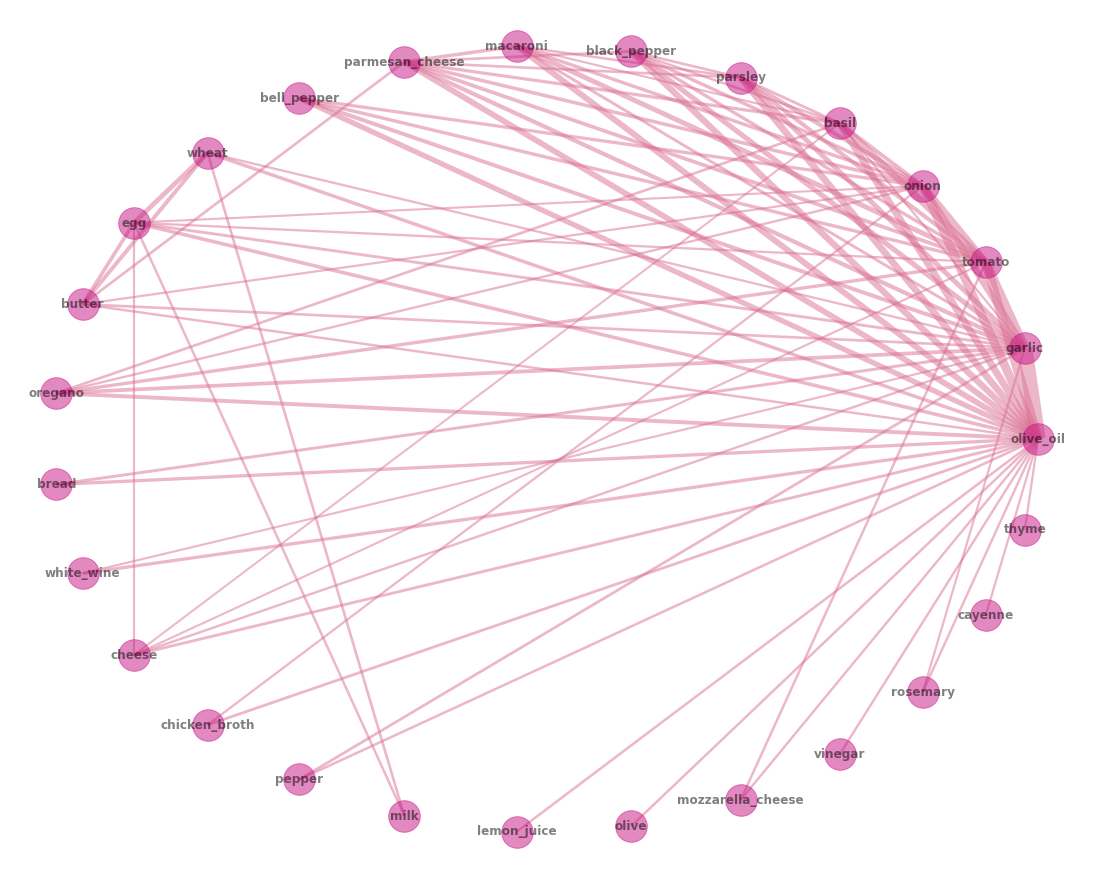

In [121]:
SE=nx.from_pandas_edgelist(pair_countsSE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in SE.edges(data=True)]
nx.draw_circular(SE, with_labels=True, node_color="mediumvioletred", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="palevioletred", alpha=0.5)

Olive oil seems to be in everything in Southern European cuisine! It creates a graphic-dominated, fan-like appearance and has a very heavy association with garlic and onions and a slightly less heavy connection with tomatoes.

The SouthernEuropean recipes in our dataset include 37037 total ingredients listed in 4180 recipes with 290 unique ingredients.

## Western European Cuisine

In [122]:
pair_countsWE=pair_counts[(pair_counts['counts']>100) & (pair_counts['Cuisine']=='WesternEuropean')]
pair_countsWE.shape

(88, 6)

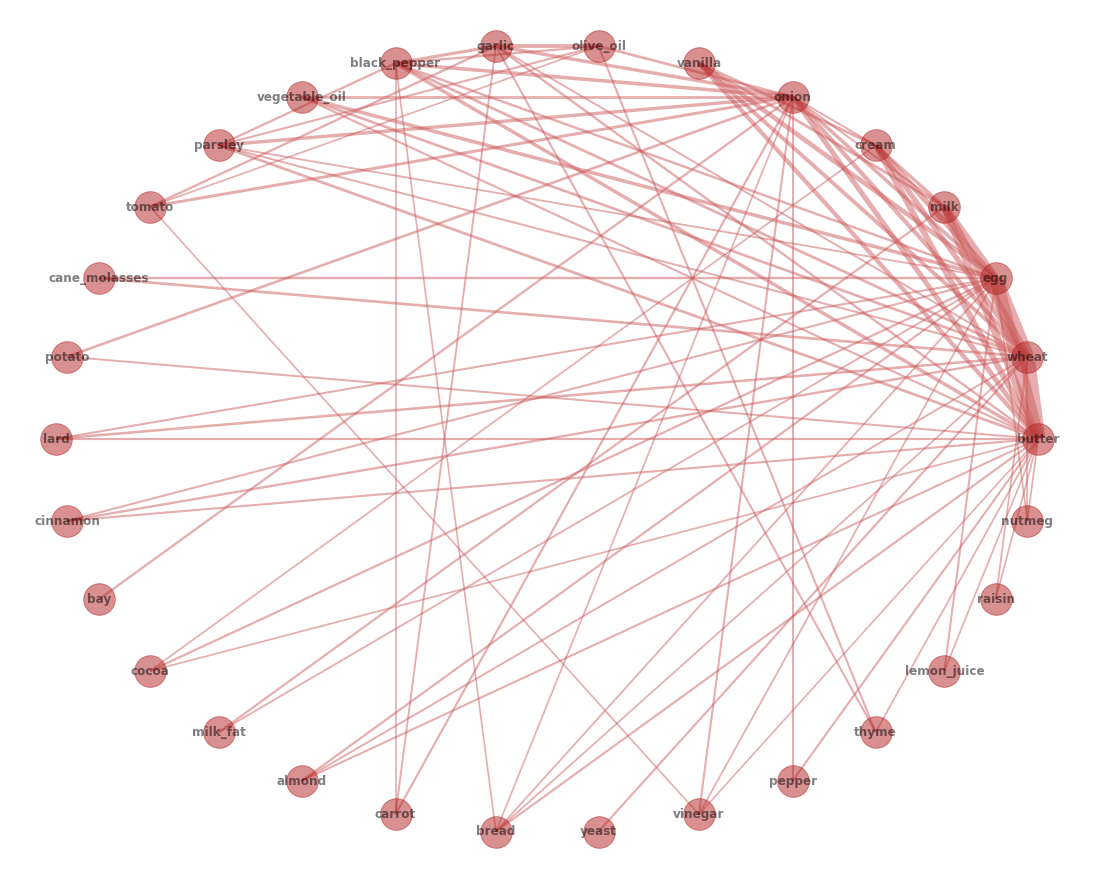

In [123]:
WE=nx.from_pandas_edgelist(pair_countsWE, 'ingred1', 'ingred2', edge_attr='percent')
weights=[edata['percent']*15 for f,t,edata in WE.edges(data=True)]
nx.draw_circular(WE, with_labels=True, node_color="firebrick", node_size=1000, font_size=12,  font_weight='bold', 
        width=weights, edge_color="indianred", alpha=0.5)

Wheat, butter, eggs and milk are front and center in Western European cuisine, as in Eastern European and North American cuisine. However, as there is only one link with wheat, yeast is noticeably almost absent here, so breads can still be part of the baking process.

The WesternEuropean recipes in our dataset include 21341 total ingredients listed in 2659 recipes with 309 unique ingredients.

## Bipartite Network Analysis

To analyze cuisines and ingredients as a two-sided network not dominated by the excess of North American recipes in our dataset, we decided to take the proportional data we calculated earlier and multiply the percentages by 10 to get the estimated number of recipes. It will include every ingredient in every kitchen in 1000. We then took the top 50 ingredients from each kitchen and created a graphic object from those with kitchens and supplies as top and bottom nodes.

In [124]:
network = cuisine_props.groupby('Cuisine').head(50).reset_index()
network['countPer1000recipes'] = round(network['percent']*10, 0)
network.head()

Cuisine ingredient   percent  countPer1000recipes
0  African  olive_oil  5.327535                 53.0
1  African      onion  5.137266                 51.0
2  African      cumin  4.512096                 45.0
3  African     garlic  4.349008                 43.0
4  African    cayenne  3.153031                 32.0

In [126]:
B = nx.Graph()
B.add_nodes_from(network['Cuisine'], bipartite=0)
B.add_nodes_from(network['ingredient'], bipartite=1)
B.add_weighted_edges_from([tuple(d) for d in network[['Cuisine','ingredient','countPer1000recipes']].values])
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 149
Number of edges: 550
Average degree:   7.3826


### 'Top' and 'Bottom' Nodes

In [127]:
cuisine_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
ingredient_nodes = set(B) - cuisine_nodes

### Density

In [128]:
print(bi.density(B, cuisine_nodes))

0.36231884057971014
